In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score

file_path = 'dataset/Wednesday-workingHours.pcap_ISCX.csv'
data = pd.read_csv(file_path)

In [3]:
df = data.copy()
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.columns = df.columns.str.strip().str.replace('[ /]', '_', regex=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

X = df.drop('Label', axis=1)
y = df['Label']
y_binary = np.where(y == 'BENIGN', 0, 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary, test_size=0.15, random_state=42, stratify=y_binary
)

print(f"Train 데이터 크기: {X_train.shape}")
print(f"Test 데이터 크기: {X_test.shape}")
print("-" * 50)

Train 데이터 크기: (588797, 78)
Test 데이터 크기: (103906, 78)
--------------------------------------------------


In [4]:
print("## 1. 전체 Feature를 사용한 모델 학습 및 평가 ##")

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20, None],
    'min_samples_leaf': [1, 3, 5]
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    scoring='f1',
    cv=3
)
grid_search.fit(X_train, y_train)

print("최적의 하이퍼파라미터:", grid_search.best_params_)
model_full = grid_search.best_estimator_

y_pred_full = model_full.predict(X_test)
accuracy_full = accuracy_score(y_test, y_pred_full)
recall_full = recall_score(y_test, y_pred_full)
f1_full = f1_score(y_test, y_pred_full)

print(f"모델 정확도: {accuracy_full:.4f}")
print(f"재현율 (Recall): {recall_full:.4f}")
print(f"F1-Score: {f1_full:.4f}")
print("성능 리포트:")
print(classification_report(y_test, y_pred_full, target_names=['BENIGN (0)', 'ATTACK (1)']))
print("-" * 50)

## 1. 전체 Feature를 사용한 모델 학습 및 평가 ##
최적의 하이퍼파라미터: {'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 100}
모델 정확도: 0.9996
재현율 (Recall): 0.9996
F1-Score: 0.9994
성능 리포트:
              precision    recall  f1-score   support

  BENIGN (0)       1.00      1.00      1.00     66005
  ATTACK (1)       1.00      1.00      1.00     37901

    accuracy                           1.00    103906
   macro avg       1.00      1.00      1.00    103906
weighted avg       1.00      1.00      1.00    103906

--------------------------------------------------


In [5]:
print("## 2. Gini 중요도 기반 상위 10개 특성 추출 ##")
importances = model_full.feature_importances_
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_importances = feature_importances.sort_values('importance', ascending=False)
top_10_feature_names = feature_importances.head(10)['feature'].tolist()

print("상위 10개 특성:")
print(feature_importances.head(10))
print("-" * 50)

## 2. Gini 중요도 기반 상위 10개 특성 추출 ##
상위 10개 특성:
                   feature  importance
54    Avg_Bwd_Segment_Size    0.072658
39       Max_Packet_Length    0.065274
10   Bwd_Packet_Length_Max    0.062226
52     Average_Packet_Size    0.056017
41       Packet_Length_Std    0.055322
0         Destination_Port    0.050446
37           Bwd_Packets_s    0.048223
13   Bwd_Packet_Length_Std    0.046351
40      Packet_Length_Mean    0.045119
42  Packet_Length_Variance    0.042129
--------------------------------------------------


In [6]:
print("## 3. 상위 6개 특성만 사용한 모델 학습 및 평가 ##")
X_train_top6 = X_train[top_10_feature_names[:6]]
X_test_top6 = X_test[top_10_feature_names[:6]]

grid_search_top6 = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    scoring='f1',
    cv=3
)
grid_search_top6.fit(X_train_top6, y_train)

print("최적의 하이퍼파라미터 (상위 6개 특성):", grid_search_top6.best_params_)
model_top6 = grid_search_top6.best_estimator_

y_pred_top6 = model_top6.predict(X_test_top6)
accuracy_top6 = accuracy_score(y_test, y_pred_top6)
recall_top6 = recall_score(y_test, y_pred_top6)
f1_top6 = f1_score(y_test, y_pred_top6)

print(f"모델 정확도: {accuracy_top6:.4f}")
print(f"재현율 (Recall): {recall_top6:.4f}")
print(f"F1-Score: {f1_top6:.4f}")
print("성능 리포트:")
print(classification_report(y_test, y_pred_top6, target_names=['BENIGN (0)', 'ATTACK (1)']))
print("-" * 50)

## 3. 상위 6개 특성만 사용한 모델 학습 및 평가 ##
최적의 하이퍼파라미터 (상위 6개 특성): {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 100}
모델 정확도: 0.9861
재현율 (Recall): 0.9994
F1-Score: 0.9813
성능 리포트:
              precision    recall  f1-score   support

  BENIGN (0)       1.00      0.98      0.99     66005
  ATTACK (1)       0.96      1.00      0.98     37901

    accuracy                           0.99    103906
   macro avg       0.98      0.99      0.99    103906
weighted avg       0.99      0.99      0.99    103906

--------------------------------------------------


In [ ]:
print("## 4. RFECV 기반 최적의 특성 개수 및 목록 추출 ##")

cv_strategy = StratifiedKFold(n_splits=3)

rfecv = RFECV(
    estimator=model_full,
    step=1,
    cv=cv_strategy,
    scoring='f1',
    n_jobs=-1
)

rfecv.fit(X_train, y_train)
rfecv.best_estimator_
best_features = X_train.columns[rfecv.support_]
print(f"\n최적의 특성 개수: {rfecv.n_features_}")
print("선택된 특성 목록:", best_features.tolist())
print("-" * 50)

## 4. RFECV 기반 최적의 특성 개수 및 목록 추출 ##


In [ ]:
print("## 5. 최적의 특성을 사용한 모델 학습 및 평가 ##")

X_train_best = X_train[best_features]
X_test_best = X_test[best_features]

model_best = grid_search.best_estimator_
model_best.fit(X_train_best, y_train)

y_pred_best = model_best.predict(X_test_best)
accuracy_best = accuracy_score(y_test, y_pred_best)
recall_best = recall_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best)

print(f"모델 정확도: {accuracy_best:.4f}")
print(f"재현율 (Recall): {recall_best:.4f}")
print(f"F1-Score: {f1_best:.4f}")
print("성능 리포트:")
print(classification_report(y_test, y_pred_best, target_names=['BENIGN (0)', 'ATTACK (1)']))
print("-" * 50)

In [ ]:
print("## 6. 최적의 하이퍼파라미터로 재학습 및 시간 측정 ##")
import time

start_time = time.time()
best_full = grid_search.best_estimator_
best_full.fit(X_train, y_train)
end_time = time.time()
print(f"전체 특성으로 재학습 시간: {end_time - start_time:.4f}초")

start_time_top6 = time.time()
best_top6 = grid_search_top6.best_estimator_
best_top6.fit(X_train_top6, y_train)
end_time_top6 = time.time()
print(f"상위 6개 특성으로 재학습 시간: {end_time_top6 - start_time_top6:.4f}초")

start_time_best = time.time()
best_model = model_best
best_model.fit(X_train_best, y_train)
end_time_best = time.time()
print(f"최적의 특성으로 재학습 시간: {end_time_best - start_time_best:.4f}초")

print("-" * 50)

## 4. 최적의 하이퍼파라미터로 재학습 및 시간 측정 ##
전체 특성으로 재학습 시간: 21.7855초
상위 6개 특성으로 재학습 시간: 6.8750초
--------------------------------------------------


In [ ]:
print("## 7. 최종 성능 비교 ##")
print("[전체 특성 사용 모델]")
print(f" - 하이퍼파라미터: {grid_search.best_params_}")
print(f" - 정확도 (Accuracy): {accuracy_full:.4f}")
print(f" - 재현율 (Recall): {recall_full:.4f}")
print(f" - F1-Score: {f1_full:.4f}")
print(f" - 학습 시간: {end_time - start_time:.4f}초")

print("[상위 6개 특성 사용 모델]")
print(f" - 하이퍼파라미터: {grid_search_top6.best_params_}")
print(f" - 정확도 (Accuracy): {accuracy_top6:.4f}")
print(f" - 재현율 (Recall): {recall_top6:.4f}")
print(f" - F1-Score: {f1_top6:.4f}")
print(f" - 학습 시간: {end_time_top6 - start_time_top6:.4f}초")

print("[최적의 특성 사용 모델]")
print(f" - 하이퍼파라미터: {grid_search.best_params_}")
print(f" - 정확도 (Accuracy): {accuracy_best:.4f}")
print(f" - 재현율 (Recall): {recall_best:.4f}")
print(f" - F1-Score: {f1_best:.4f}")
print(f" - 학습 시간: {end_time_best - start_time_best:.4f}초")

print("-" * 50)

## 5. 최종 성능 비교 ##
[전체 특성 사용 모델]
 - 하이퍼파라미터: {'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 100}
 - 정확도 (Accuracy): 0.9995
 - 재현율 (Recall): 0.9996
 - F1-Score: 0.9994
 - 학습 시간: 21.7855초
[상위 6개 특성 사용 모델]
 - 하이퍼파라미터: {'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 100}
 - 정확도 (Accuracy): 0.9861
 - 재현율 (Recall): 0.9993
 - F1-Score: 0.9813
 - 학습 시간: 6.8750초
--------------------------------------------------


## 6. ROC curve 및 AUC ##


Text(0.5, 1.0, 'ROC Curve')

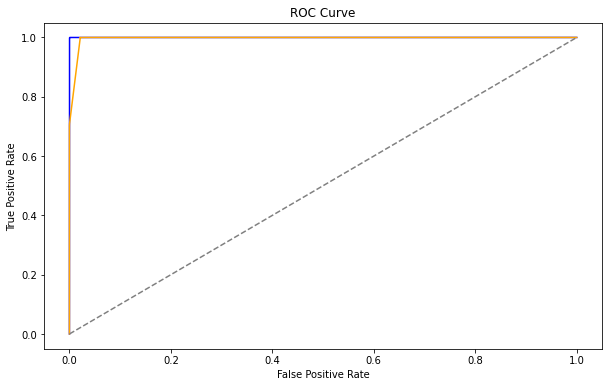

In [ ]:
print("## 8. ROC curve 및 AUC ##")
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc

y_scores_full = model_full.predict_proba(X_test)[:, 1]
y_scores_top6 = model_top6.predict_proba(X_test_top6)[:, 1]
y_scores_best = best_model.predict_proba(X_test_best)[:, 1]

fpr_full, tpr_full, _ = roc_curve(y_test, y_scores_full)
fpr_top6, tpr_top6, _ = roc_curve(y_test, y_scores_top6)
fpr_best, tpr_best, _ = roc_curve(y_test, y_scores_best)
roc_auc_full = auc(fpr_full, tpr_full)
roc_auc_top6 = auc(fpr_top6, tpr_top6)
roc_auc_best = auc(fpr_best, tpr_best)

plt.figure(figsize=(10, 6))
plt.plot(fpr_full, tpr_full, color='blue', label=f'전체 특성 (AUC = {roc_auc_full:.2f})')
plt.plot(fpr_top6, tpr_top6, color='orange', label=f'상위 6개 특성 (AUC = {roc_auc_top6:.2f})')
plt.plot(fpr_best, tpr_best, color='green', label=f'최적의 특성 (AUC = {roc_auc_best:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve')

In [ ]:
## 모델 저장
import joblib
import os

print("## 전체 특성 모델 저장")
save_path_full = 'models/rf_model_full.pkl'
os.makedirs(os.path.dirname(save_path_full), exist_ok=True)
joblib.dump(model_full, save_path_full)

print("## 상위 6개 특성 모델 저장")
save_path_top6 = 'models/rf_model_top6.pkl'
os.makedirs(os.path.dirname(save_path_top6), exist_ok=True)
joblib.dump(model_top6, save_path_top6)

print("## 최적의 특성 모델 저장")
save_path_best = 'models/rf_model_best.pkl'
os.makedirs(os.path.dirname(save_path_best), exist_ok=True)
joblib.dump(best_model, save_path_best)

file_top6_features = 'models/top6_features.txt'
with open(file_top6_features, 'w') as f:
    for features in top_10_feature_names[:6]:
        f.write(f"{features}\n")

file_best_features = 'models/best_features.txt'
with open(file_best_features, 'w') as f:
    for features in best_features:
        f.write(f"{features}\n")

print("저장이 완료되었습니다.")

## 전체 특성 모델 저장
## 상위 6개 특성 모델 저장
저장이 완료되었습니다.
